# One layer model

Here we show how to run our two-layer model as a single-layer model. There are two different ways to do this, which we present below.

## Imports and loading data

In [1]:
# NBVAL_IGNORE_OUTPUT
import os.path

import numpy as np
import pandas as pd
from openscm_units import unit_registry as ur
import tqdm.autonotebook as tqdman
from scmdata import ScmRun, run_append

from openscm_twolayermodel import TwoLayerModel

import matplotlib.pyplot as plt

/Users/znicholls/Documents/AGCEC/MCastle/openscm-twolayermodel/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


For this we use an idealised scenario which is a reasonable representation of the forcing which occurs in response to an abrupt doubling in atmospheric CO$_2$ concentrations (often referred to as an abrupt-2xCO2 experiment).

In [2]:
run_length = 2000

data = np.zeros(run_length)
data[10 : ] = 4.0

driver = ScmRun(
    data=data,
    index=1850 + np.arange(run_length),
    columns={
        "unit": "W/m^2",
        "model": "idealised",
        "scenario": "1pctCO2",
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
driver

<scmdata.ScmRun (timeseries: 1, timepoints: 2000)>
Time:
	Start: 1850-01-01T00:00:00
	End: 3849-01-01T00:00:00
Meta:
	       model region scenario   unit                     variable
	0  idealised  World  1pctCO2  W/m^2  Effective Radiative Forcing

<AxesSubplot:xlabel='time', ylabel='W/m^2'>

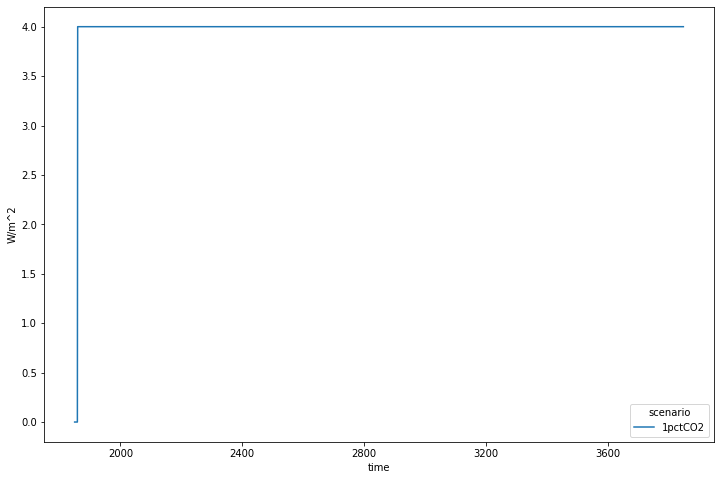

In [3]:
# NBVAL_IGNORE_OUTPUT
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
driver.filter(variable="Effective Radiative Forcing").lineplot()

## No second layer

The first, and arguably the simplest way, to make a single layer model is to simply remove the connection between the top and second layers. Recalling the equations which define the two-layer model below,

\begin{align}
C \frac{dT}{dt} & = F - (\lambda_0 - a T) T - \epsilon \eta (T - T_D) \\
C_D \frac{dT_D}{dt} & = \eta (T - T_D)
\end{align}

We see that we can effectively remove the second layer by setting $\eta = 0$.

In [4]:
TwoLayerModel().eta

0.8 <Unit('watt / delta_degree_Celsius / meter ** 2')>

In [5]:
# NBVAL_IGNORE_OUTPUT
eta_values = np.array([0, 0.8]) * ur("W/m^2/K")
eta_values

Magnitude,[0.0 0.8]
Units,watt/(kelvin meter2)


In [6]:
# NBVAL_IGNORE_OUTPUT
du_values = np.array([50, 250, 500]) * ur("m")
du_values

Magnitude,[ 50 250 500]
Units,meter


In [7]:
# NBVAL_IGNORE_OUTPUT
runner = TwoLayerModel()
output = []
equivalent_parameters = []
for eta in tqdman.tqdm(eta_values, desc="eta values", leave=False):
    runner.eta = eta
    for du in tqdman.tqdm(du_values, desc="du values", leave=False):
        runner.du = du
        output.append(runner.run_scenarios(driver))

output = run_append(output)
output.head()

time                                                                                                                                                                                                                                                                         1850-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model     region run_idx scenario unit       variable                                           
0.0                                               two_layer     1200       50         1.0                      0.0                              1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   
                                                                                                                                                                                                                                     delta_degC Surface Temperature|Upper                    0.0   
                                                                                                                                                                                                                                                Surface Temperature|Lower                    0.0   
                                                                                                                                                                                                                                     W/m^2      Heat Uptake                                  0.0   
                                                                           250        1.0                      0.0                              1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   

time                                                                                                                                                                                                                                                                         1851-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / kelvin / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model     region run_idx scenario unit       variable                                           
0.0                                               two_layer     1200       50         1.0                      0.0                              1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   
                                                                                                                                                                                                                                     delta_degC Surface Temperature|Upper                    0.0   
                                                                                                                                                                                                                                                Surface Temperature|Lower                    0.0   
                                                                                                                                                                                                                                     W/m^2      Heat Uptake                                  0.0   
                                                                           250        1.0                      0.0                              1.246667                                           idealise

As we can see in the plots below, the runs with $\eta = 0$ only have a single timescale in their response. In contrast, the runs with $\eta \neq 0$ have two clear, distinct timescales. Notably, because equilibrium warming is independent of ocean heat uptake, the equilibrium warming is the same in all cases.

As expected, we see that the depth of the mixed-layer affects the response time of the mixed-layer (the only response time in the case of $\eta = 0$) whilst having a much smaller effect on the response time of the deep ocean.

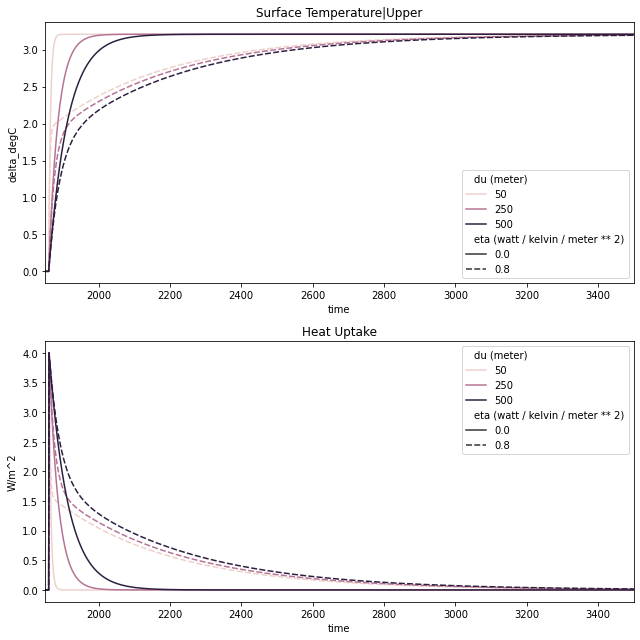

In [8]:
# NBVAL_IGNORE_OUTPUT
scenario_to_plot = "1pctCO2"
xlim = [1850, 3500]
pkwargs = dict(
    hue="du (meter)", 
    style="eta (watt / kelvin / meter ** 2)", 
    time_axis="year"
)
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(211)
output.filter(scenario=scenario_to_plot, variable="Surface Temperature|Upper").lineplot(**pkwargs, ax=ax)
ax.set_title("Surface Temperature|Upper")

ax = fig.add_subplot(212, sharex=ax)
output.filter(scenario=scenario_to_plot, variable="Heat Uptake").lineplot(**pkwargs, ax=ax)
ax.set_title("Heat Uptake")
ax.set_xlim(xlim)

plt.tight_layout()

## Infinite reservoir second layer

If we make the deep ocean component of the two-layer model infinitely deep, then we also have a single layer model. The concept is described by Equation 4 of [Geoffroy et al. 2013, Part 1](https://journals.ametsoc.org/doi/10.1175/JCLI-D-12-00195.1).

\begin{align}
C \frac{dT}{dt} & = F - (\lambda_0 - a T) T - \epsilon \eta (T - T_D) \\
C_D \frac{dT_D}{dt} & = \eta (T - T_D)
\end{align}

In short, if $C_D \rightarrow \infty$, then $T_D = 0$ and the equation governing the mixed layer response becomes

\begin{align}
C \frac{dT}{dt} & = F - (\lambda_0 - a T) T - \epsilon \eta T
\end{align}

In effect, we alter the climate feedback factor from $\lambda_0 - a T$ to $\lambda_0 - a T + \epsilon \eta$ we increase the climate feedback factor and hence lower the equilibrium climate sensitivity.

In [9]:
# NBVAL_IGNORE_OUTPUT
dl_values = np.array([10 ** 3, 10 ** 4, 10 ** 5, 10 ** 15]) * ur("m")
dl_values

Magnitude,[ 1000 10000 100000 1000000000000000]
Units,meter


In [10]:
# NBVAL_IGNORE_OUTPUT
runner = TwoLayerModel()
output = []
equivalent_parameters = []
for dl in tqdman.tqdm(dl_values, desc="dl values", leave=False):
    runner.dl = dl
    output.append(runner.run_scenarios(driver))
    equivalent_parameters.append(({"two-layer deep ocean depth": runner.dl}, runner.get_impulse_response_parameters()))

output = run_append(output)
output.head()

time                                                                                                                                                                                                                                                                                       1850-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / delta_degree_Celsius / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model     region run_idx scenario unit       variable                                           
0.0                                               two_layer     1000       50         1.0                      0.8                                            1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   
                                                                                                                                                                                                                                                   delta_degC Surface Temperature|Upper                    0.0   
                                                                                                                                                                                                                                                              Surface Temperature|Lower                    0.0   
                                                                                                                                                                                                                                                   W/m^2      Heat Uptake                                  0.0   
                                                                10000      50         1.0                      0.8                                            1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   

time                                                                                                                                                                                                                                                                                       1851-01-01 00:00:00  \
a (watt / delta_degree_Celsius ** 2 / meter ** 2) climate_model dl (meter) du (meter) efficacy (dimensionless) eta (watt / delta_degree_Celsius / meter ** 2) lambda0 (watt / delta_degree_Celsius / meter ** 2) model     region run_idx scenario unit       variable                                           
0.0                                               two_layer     1000       50         1.0                      0.8                                            1.246667                                           idealised World  0       1pctCO2  W/m^2      Effective Radiative Forcing                  0.0   
                                                                                                                                                                                                                                                   delta_degC Surface Temperature|Upper                    0.0   
                                                                                                                                                                                                                                                              Surface Temperature|Lower                    0.0   
                                                                                                                                                                                                                                                   W/m^2      Heat Uptake                                  0.0   
                     

As we can see below, as the deep ocean becomes deeper and deeper, its equivalent timescale increases. This demonstrates that the deep ocean is becoming increasingly close to being an infinite reservoir.

In [11]:
for v in equivalent_parameters:
    v[1]["d1"] = v[1]["d1"].to("yr")
    v[1]["d2"] = v[1]["d2"].to("yr")
    
equivalent_parameters

[({'two-layer deep ocean depth': 1000 <Unit('meter')>},
  {'d1': 3.211845269334279 <Unit('a')>,
   'd2': 273.9854219906419 <Unit('a')>,
   'q1': 0.4810875417166762 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.32105149571648217 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'efficacy': 1.0 <Unit('dimensionless')>}),
 ({'two-layer deep ocean depth': 10000 <Unit('meter')>},
  {'d1': 3.2342013046041056 <Unit('a')>,
   'd2': 2720.915300585768 <Unit('a')>,
   'q1': 0.4878523568580023 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.3142866805751838 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'efficacy': 1.0 <Unit('dimensionless')>}),
 ({'two-layer deep ocean depth': 100000 <Unit('meter')>},
  {'d1': 3.2364276918618766 <Unit('a')>,
   'd2': 27190.435420502465 <Unit('a')>,
   'q1': 0.4885246922441889 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'q2': 0.31361434518885845 <Unit('delta_degree_Celsius * meter ** 2 / watt')>,
   'efficacy

As shown in the plots below, as the deep ocean becomes bigger, it can uptake more heat and hence mixed-layer warming is reduced. However, whilst the deep ocean is finite, the mixed-layer warming does eventually reach the same equilibrium (independent of deep ocean depth), it just takes longer to do so. Once the deep ocean becomes infinite, as discussed above, we effectively have a single-layer model with an increased climate feedback factor (lower equilibrium climate sensitivity) which can uptake heat forever.

(1850.0, 3500.0)

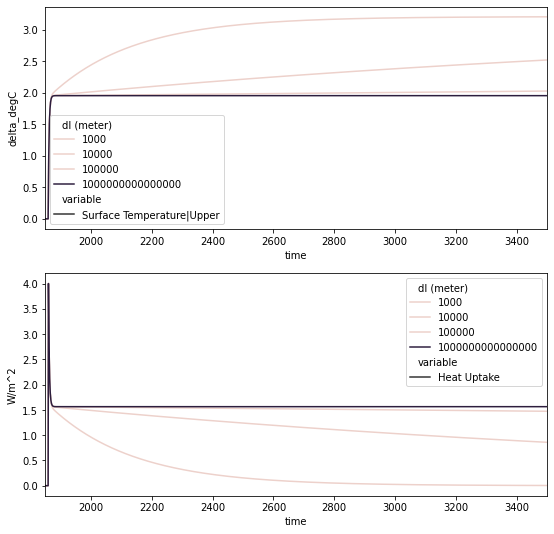

In [12]:
# NBVAL_IGNORE_OUTPUT
scenario_to_plot = "1pctCO2"
xlim = [1850, 3500]
pkwargs = dict(
    hue="dl (meter)", 
    style="variable", 
    time_axis="year"
)
fig = plt.figure(figsize=(9, 9))

ax = fig.add_subplot(211)
output.filter(scenario=scenario_to_plot, variable="Surface Temperature|Upper").lineplot(**pkwargs, ax=ax)

ax = fig.add_subplot(212, sharex=ax)
output.filter(scenario=scenario_to_plot, variable="Heat Uptake").lineplot(**pkwargs, ax=ax)
ax.set_xlim(xlim)